In [7]:
%run functions.py

import numpy as np
import pandas as pd
from scipy.io import loadmat

from sklearn.svm import LinearSVC
from sklearn.linear_model import Lasso,ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


## Load settings

In [8]:
pd.set_option('display.max_colwidth',-1)

k=10 # Define k for crossvalidation
seed = 42 # Seed to use
feature_tot = 0 # Total selected features -> Start at 0 before PCA

scoring='accuracy' # Scoring method for GridsearchCV
score_function = f_classif # Score function for Feature selection


np.random.seed(seed) # Define the random seed

In [9]:
# Define models that should be trained
estimators = [
    ('clf', LinearSVC()),
]
param_grid = [
    {
        'clf':[LinearSVC()],
        'clf__penalty':['l1','l2'],
        'clf__C': [0.1,0.5,1,1.5,2.0],
        'clf__dual':[True,False]
    },{
        'clf':[KNeighborsClassifier()],
        'clf__n_neighbors':[5,3,6,8],
        'clf__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
        'clf__leaf_size':[30,15,20,40]
    },{
        'clf':[SVC()],
        'clf__C':[1,0.5,1,5.2],
        'clf__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
        'clf__degree':[1,2,3],
        'clf__gamma':['scale', 'auto'],
        'clf__max_iter':[-1,1000,5000,10000],
}]


# Task 5 - Classification 

## Load dataset

In [10]:
filename = "datasets/ECGITtrain.mat"

mat = loadmat(filename)
input_train = mat['inputECGITtrain']

target_train = mat['outputECGITtrain'].reshape(len(input_train))
input_test = mat['inputECGITtest']

## Data info

In [11]:
get_data_info(input_train, target_train)

Length of 200
X.shape: (200, 312) y.shape: (200,)
Contains Nan: False False
Contains +inf: False False
Contains -inf: False False


## Preprocess
Normalize the dataset

In [12]:
input_train, input_test, target_train, input_train_copy, input_train_copy_normalized = preprocessing(input_train,target_train, input_test)

200


## Feature reduction
Reduce dimensionality by PCA transform

In [13]:
feature_tot, pca, pca_input = feature_reduction(input_train, target_train,input_train_copy)

original shape:    (200, 312)
transformed shape: (200, 68)
Explained variance: [0.13689165 0.10947223 0.08835791 0.05714188 0.03852058 0.03348119
 0.02998714 0.02927492 0.02559136 0.02323128 0.02056029 0.01891973
 0.01810861 0.01627311 0.01578273 0.01518965 0.01288996 0.01232019
 0.01165783 0.01106354 0.01025566 0.01020286 0.00963132 0.00899118
 0.00888426 0.00835079 0.00780978 0.00768602 0.00738474 0.00729493
 0.00691865 0.00648512 0.0063632  0.00611334 0.0060643  0.00559347
 0.00536385 0.00515121 0.00511318 0.00485909 0.00444808 0.00431979
 0.00426217 0.0040189  0.00380549 0.00361753 0.00353812 0.00350734
 0.00327855 0.00316379 0.00309998 0.00306435 0.00289113 0.00285685
 0.00281515 0.00262383 0.00255781 0.00252214 0.00235482 0.00228139
 0.00223909 0.00213703 0.00210408 0.00206141 0.00195353 0.00191249
 0.00182698 0.00179275]


# Plot PCA

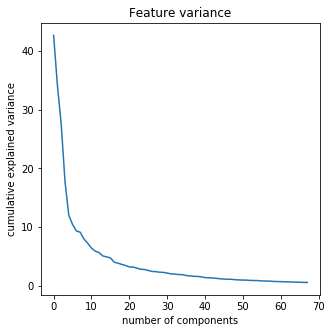

In [14]:
plot_feature_variance(pca_input)

## Plot top 10 histogram over reduced features

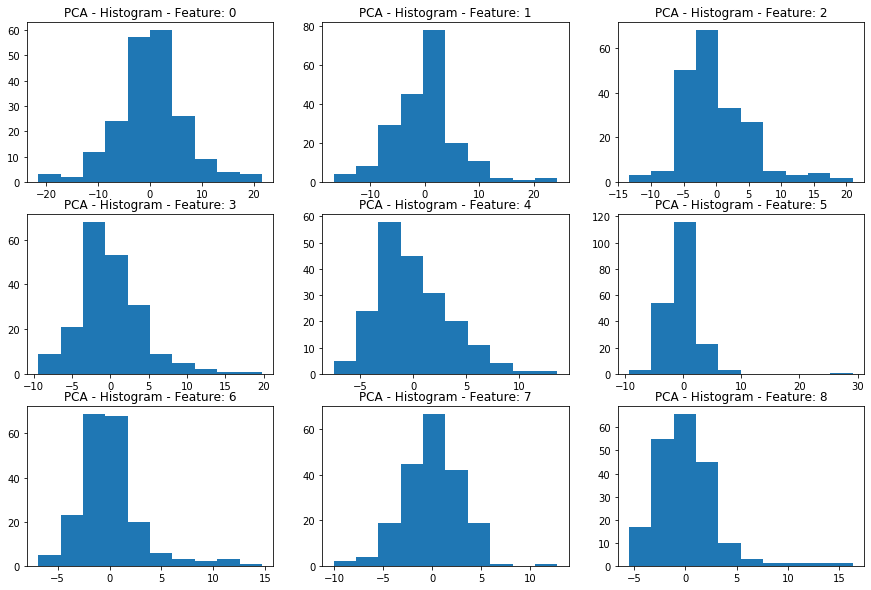

In [15]:
plot_top_features(feature_tot,pca_input)

# Feature selection
Extract top features above depending on PCA

(200, 312)


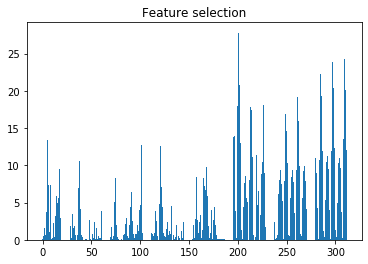

In [16]:
input_train_fs, input_test_fs = feature_selection(score_function, input_train, target_train, input_test, feature_tot=feature_tot)

## Hyperparameter tuning

In [17]:
# GridSearchCV
grid = parameter_tuning(estimators, param_grid, scoring, input_train_fs, target_train, k)


## Get Model info

In [18]:
get_model_info(grid)

Best score: 0.8100000000000002
Best params {'clf': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform'), 'clf__algorithm': 'auto', 'clf__leaf_size': 30, 'clf__n_neighbors': 3}


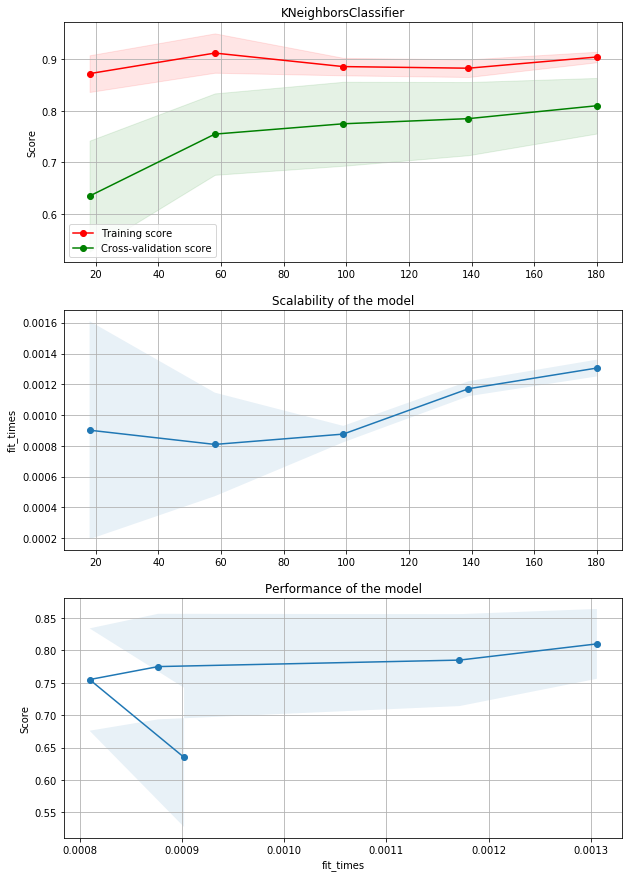

In [19]:
validate_curve(grid, input_train_fs, target_train,scoring=scoring, k=k)

# Predict testset

In [20]:
model = predict_model(grid, input_train_fs, target_train, input_test_fs)

[0 1 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 0
 0 0 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0]
